# Exercise 3: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
6. Answer to the qualitative question should be written in **markdown** cells (with $\LaTeX$ support).

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: 317887230_315372540

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):
    X = np.array(X)
    y = np.array(y)

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

In [4]:
training_set

,x1,x2,y
0,-1.385789,9.131464,0
1,-2.236903,5.561178,0
2,-2.362524,5.215973,0
3,-0.499655,4.981781,0
4,-2.976062,6.236138,0
...,...,...,...
1995,7.386494,2.598401,1
1996,5.119879,2.730597,1
1997,7.424200,1.774931,1
1998,6.670740,0.335701,1


## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

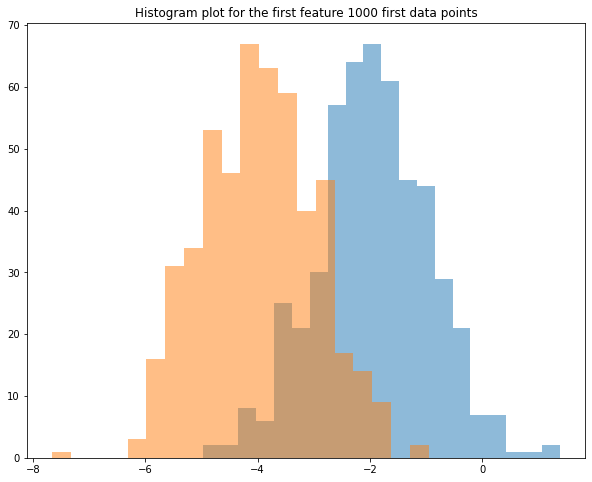

In [5]:
X_training = pd.DataFrame(X_training)

# 1. histogram plot for the first feature 1000 first data points 
x1_class0_1000 = X_training.iloc[[i for i, x in enumerate(y_training.tolist()[0:1000]) if x == 0]].iloc[:,:1]
x1_class1_1000 = X_training.iloc[[i for i, x in enumerate(y_training.tolist()[0:1000]) if x == 1]].iloc[:,:1]
plt.hist(x = x1_class0_1000, bins=20, alpha=0.5)
plt.hist(x = x1_class1_1000, bins=20, alpha=0.5)
plt.title("Histogram plot for the first feature 1000 first data points")
plt.show()

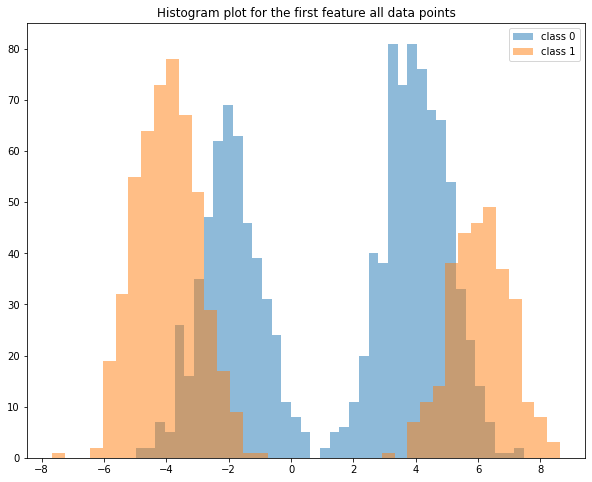

In [6]:
# 2. histogram plot for the first feature all data points 
x1_class0_all = X_training.iloc[[i for i, x in enumerate(y_training.tolist()) if x == 0]].iloc[:,:1]
x1_class1_all = X_training.iloc[[i for i, x in enumerate(y_training.tolist()) if x == 1]].iloc[:,:1]
plt.hist(x = x1_class0_all, bins=40, alpha=0.5, label = "class 0")
plt.hist(x = x1_class1_all, bins=40, alpha=0.5, label = "class 1")
plt.title("Histogram plot for the first feature all data points")
plt.legend()
plt.show()

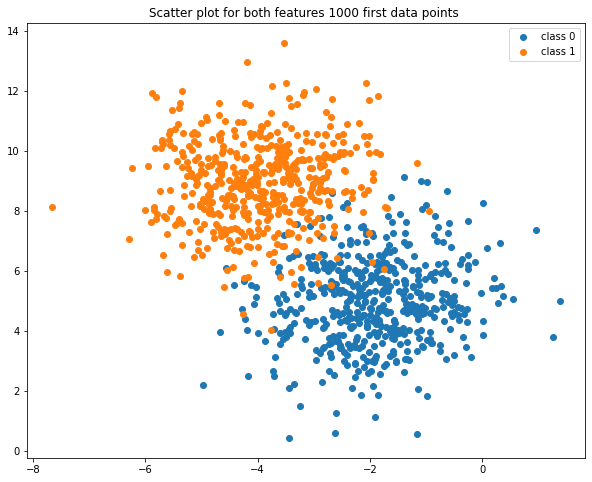

In [7]:
# 1. scatter plot for both features 1000 first data points 
x2_class0_1000 = X_training.iloc[[i for i, x in enumerate(y_training.tolist()[0:1000]) if x == 0]].iloc[:,1:]
x2_class1_1000 = X_training.iloc[[i for i, x in enumerate(y_training.tolist()[0:1000]) if x == 1]].iloc[:,1:]

plt.scatter(x = x1_class0_1000, y = x2_class0_1000, label = "class 0")
plt.scatter(x = x1_class1_1000, y = x2_class1_1000, label = "class 1")
plt.title("Scatter plot for both features 1000 first data points ")
plt.legend()
plt.show()

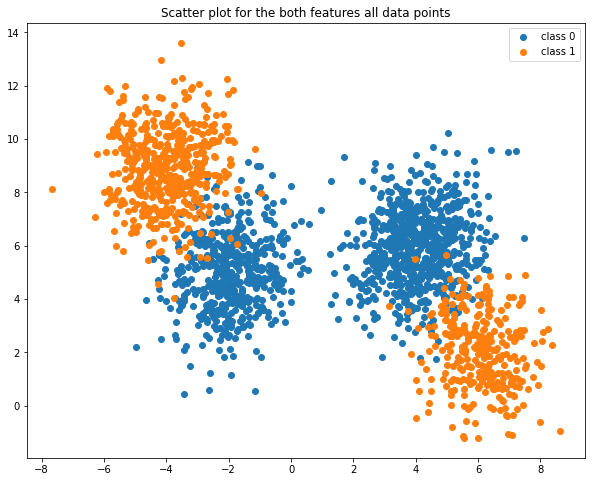

In [8]:
# 2. scatter plot for the both features all data points 
x2_class0_all = X_training.iloc[[i for i, x in enumerate(y_training.tolist()) if x == 0]].iloc[:,1:]
x2_class1_all = X_training.iloc[[i for i, x in enumerate(y_training.tolist()) if x == 1]].iloc[:,1:]

plt.scatter(x = x1_class0_all, y = x2_class0_all, label = "class 0")
plt.scatter(x = x1_class1_all, y = x2_class1_all, label = "class 1")
plt.title("Scatter plot for the both features all data points")
plt.legend()
plt.show()

## Logistic Regression

(20 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [9]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        #### Your code here ####
        
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """

        # First initialize weights
        r_state = np.random.RandomState(self.random_state)
        self.theta = np.random.normal(loc = 0.0, scale = 1, size = 1 + X.shape[1])
        self.cost = []
        old_cost = 0
        output = []
        
        # Iterately update weights
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = output - y
            self.theta[1:] -= self.eta * X.T.dot(errors)
            self.theta[0] -= self.eta * errors.sum()
           
            # Compute the logistic `cost` now instead of the sum of squared errors cost
            cost = (-y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))).sum() / X.shape[0] 
            
            self.cost.append(cost)
            
            if abs(cost - old_cost) < self.eps:
                break
            
            old_cost = cost
                    
        return self  

    # Calculate net input
    def net_input(self, X):
        return np.dot(X, self.theta[1:]) + self.theta[0]
   
    # Return the predicted class label
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)
    
    # Return the predicted class label
    def predict_prob (self, X):
        return self.activation(self.net_input(X))
    
    # Compute logistic sigmoid activation
    def activation(self, z):
        return 1.0 / (1.0 + np.exp(-np.clip(z, -250,250)))      

## Cross Validation

(10 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [10]:
X_training_lg = X_training.values

In [11]:
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

def cross_validation(X, Y, k):
    
    np.random.seed(23)
    random_rows = np.random.choice(a = np.arange(0,X.shape[0], dtype = int), size = X.shape[0], replace = False)
    folds_data_idx = np.array_split(random_rows, k)
    
    x_train = []
    y_train = []
    
    x_val = []  
    y_val = []
    
    best_result = 0
    
    for ep in epss:
        for et in etas:
            results = []
            for i in range(0, k):
                x_val = X[folds_data_idx[i]]
                y_val = Y[folds_data_idx[i]]

                x_train = X[[x for x in range(X.shape[0]) if x not in folds_data_idx[i]]]
                y_train = Y[[y for y in range(Y.shape[0]) if y not in folds_data_idx[i]]]
                
                model = LogisticRegressionGD(eps = ep, eta = et)
                model.fit(np.array(x_train), np.array(y_train))
                result_acc = (model.predict(x_val) == y_val).sum() / (X.shape[0] / k)
                results.append(result_acc)
                
            avg_result = sum(results) / k
            #print(f"The score for eta {et} and eps {ep} is {avg_result}")

            if avg_result > best_result:
                best_result = avg_result
                best_parameters = [et, ep]
    

    print(f"The best eta is {best_parameters[0]:.5f} and best eps is {best_parameters[1]:.5f} with score of {best_result}")

    return best_parameters, best_result

In [12]:
best_parameters, max_res = cross_validation(X_training_lg, y_training ,5)    

The best eta is 0.00005 and best eps is 0.00000 with score of 0.8254999999999999


## Normal distribution pdf

(5 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [13]:
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    normal_distribution = (1 / (sigma*(2*np.pi*sigma) ** 0.5)) * np.exp(-0.5*((-(data-mu) / sigma) ** 2))
    return normal_distribution

## Expectation Maximization

(20 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{i=1}^{m}-log\bigg(\sum_{j=1}^{k}w_j * pdf(x_i; \mu_j, \sigma_j)\bigg)
$$

\* Where i is the index of the instances (from 1 to m) and j is the index of the gaussian in the GMM (from 1 to k). 

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function (this function calls the init_params and then iteratively calls expectation and maximization)
1. get_dist_params - return the params of the distribution (the GMM distribution) 

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [14]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps

    def init_params(self, data):
        """
        Initialize distribution params
        """

    # Initialiizing parameters
    def init_params(self, data):
        """
        Initialize distribution params 
        """   
                
        self.r = [] # responsibilities list
        for i in range(self.k):
            self.r.append(None)
        
        self.w = []
        self.mu = []
        self.std = []

        if self.k == 1:
            self.w.append(1)
            self.mu.append(np.mean(data))
            self.std.append(np.std(data))
        else:
            
            self.w.append(0.5)
            self.w.append(0.5)
            self.mu.append(np.mean(data[data < np.median(data)]))     
            self.std.append(np.std(data[data < np.median(data)]))  
        

            self.mu.append(np.mean(data[data >= np.median(data)]))     
            self.std.append(np.std(data[data >= np.median(data)]))     
        
        
    def expectation(self, data):
        """
        E step - calculating responsibilities 
        """        
        
        for i in range(len(self.r)):
            self.r[i] = np.multiply(np.array(norm_pdf(data,self.mu[i], self.std[i])), self.w[i])
    
        denominator = self.r[0] 
        
 
        for i in range(1,len(self.r)):
            denominator = np.add(denominator,self.r[i])
            
        for i in range(len(self.r)):
            self.r[i] = np.divide(self.r[i], denominator)  


    def maximization(self, data):
        """
        M step - updating distribution params
        """ 
        for i in range(len(self.w)):
            self.w[i] = np.mean(self.r[i])
            
                               
            self.mu[i] = np.mean(np.multiply(data, self.r[i])) * (1/self.w[i])
                               
            self.std[i] = np.sum(np.multiply(self.r[i], (data - self.mu[i]) ** 2)) / (self.w[i] * len(data))
        
        
            
                               
    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        iter_count = 0
        old_cost = 0
        cost = 0       
        while iter_count <= self.n_iter:
        
            self.expectation(data)
        
            self.maximization(data)
            


            cost1 = np.zeros((len(data), 1))
            for i in range(self.k):
                cost1 = np.add(cost1, np.multiply(norm_pdf(
                    data, self.mu[i], self.std[i]), self.w[i]))
                cost = float(np.sum(-np.log(cost1)))
            

            if abs(cost - old_cost) < self.eps:
                break
             
            old_cost = cost
                               
            
            iter_count += 1
            

    def get_dist_params(self):
        return self.w, self.mu, self.std
    
    def get_lhd(self, X):
        lhd = 0
        
        for i in range(self.k):
            lhd += self.w[i] * norm_pdf(X, self.mu[i], self.std[i])
        return np.array(lhd)
        

## Naive Bayes

(20 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [15]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        X = pd.DataFrame(X)

        self.classes, self.counts = np.unique(y, return_counts=True)
        self.prop = []
        for i in range(2):
            self.prop.append(self.counts[i] / np.sum(self.counts))
        
        
        
        
        # class 0
        # feature 1
        self.model_class_0_feature_1 = EM(k = self.k)
        self.model_class_0_feature_1.fit(np.array(X.loc[y == 0].iloc[:,0]))
                                    
        # feature 2
        self.model_class_0_feature_2 = EM(k = self.k)
        self.model_class_0_feature_2.fit(np.array(X.loc[y == 0].iloc[:,1:]))   
                                    
        # class 1
        # feature 1
        self.model_class_1_feature_1 = EM(k = self.k)
        self.model_class_1_feature_1.fit(np.array(X.loc[y == 1].iloc[:,0]))
                                    
        # feature 2
        self.model_class_1_feature_2 = EM(k = self.k)
        self.model_class_1_feature_2.fit(np.array(X.loc[y == 1].iloc[:,1:])) 
                                    
                                    
        
    
    def predict(self, X):
        """Return the predicted class label"""
        
        X = pd.DataFrame(X)
        # Calculation the posterior of class 1
        lhd_0_1 = self.model_class_0_feature_1.get_lhd(X.iloc[:,:1])
        
        lhd_0_2 = self.model_class_0_feature_2.get_lhd(X.iloc[:,1:])
        
        posterior_class_0 = self.prop[0] * lhd_0_1 * lhd_0_2

        # Calculation the posterior of class 1
        lhd_1_1 = self.model_class_1_feature_1.get_lhd(X.iloc[:,:1])
        
        lhd_1_2 = self.model_class_1_feature_2.get_lhd(X.iloc[:,1:])
        
        posterior_class_1 = self.prop[1] * lhd_1_1 * lhd_1_2
        
        preds = np.zeros(len(posterior_class_0))
        for i in range(len(preds)):
            if posterior_class_1[i] > posterior_class_0[i]:
                preds[i] = 1

        return preds

## Model evaluation

(10 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points

In [16]:
# 1000 training points 
X_training_1000 = X_training.iloc[:1000,:]
y_training_1000 = y_training[0:1000]

# 500 test set points
X_test_500 = X_test[:500, :]
y_test_500 = y_test[0:500]


In [17]:
# Fitting Logistic Regression model with the best params you found earlier
LR_model_1000 = LogisticRegressionGD(eta = best_parameters[0], eps = best_parameters[1])
LR_model_1000.fit(X_training_1000,y_training_1000)

# Fitting Naive Bayes model
NB_model_1000 = NaiveBayesGaussian(k=1)
NB_model_1000.fit(X_training_1000, y_training_1000)


In [18]:
# Calculating the training and test accuracies for each model
LR_preds_train_1000 = LR_model_1000.predict(X_training_1000)
LR_accuracy_train_1000 = np.sum(LR_preds_train_1000 == y_training_1000) / len(y_training_1000)

LR_preds_test_1000 = LR_model_1000.predict(X_test_500)
LR_accuracy_test_1000 = np.sum(LR_preds_test_1000 == y_test_500) / len(y_test_500)

# Print the training and test accuracies for each model
print("Logistic regression train accuracy trained on 1000 data points:", LR_accuracy_train_1000)
print("Logistic regression test accuracy trained on 1000 data points:", LR_accuracy_test_1000)

Logistic regression train accuracy trained on 1000 data points: 0.964
Logistic regression test accuracy trained on 1000 data points: 0.938


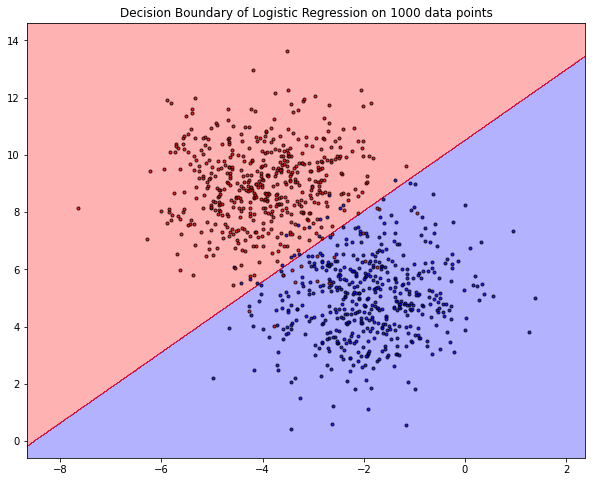

In [19]:
plot_decision_regions(X_training_1000, y_training_1000, LR_model_1000)
plt.title("Decision Boundary of Logistic Regression on 1000 data points")
plt.show()

In [20]:
# Calculating the training and test accuracies for each model
NB_preds_train_1000 = NB_model_1000.predict(X_training_1000)
NB_accuracy_train_1000 = np.sum(NB_preds_train_1000 == y_training_1000) / len(y_training_1000)

NB_preds_test_1000 = NB_model_1000.predict(X_test_500)
NB_accuracy_test_1000 = np.sum(NB_preds_test_1000.reshape(len(NB_preds_test_1000)) == np.array(y_test_500)) / len(y_test_500)

# Print the training and test accuracies for each model
print("Gaussian NB train accuracy for 1000 data points:", NB_accuracy_train_1000)
print("Gaussian NB test accuracy for 1000 data points:", NB_accuracy_test_1000)

Gaussian NB train accuracy for 1000 data points: 0.951
Gaussian NB test accuracy for 1000 data points: 0.94


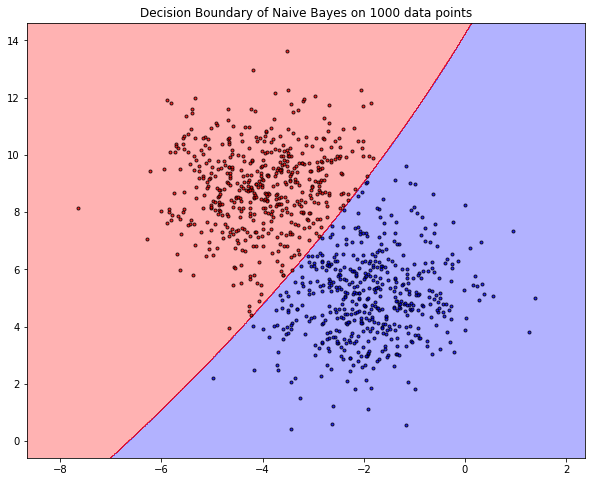

In [21]:
plot_decision_regions(X_training_1000, NB_preds_train_1000, NB_model_1000)
plt.title("Decision Boundary of Naive Bayes on 1000 data points")
plt.show()

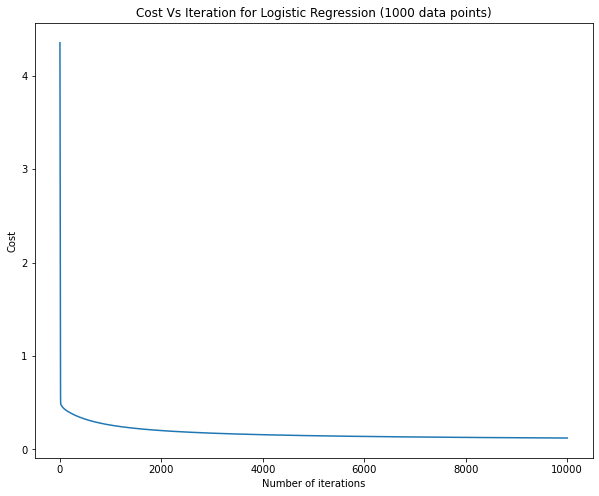

In [22]:
plt.plot(LR_model_1000.cost)
plt.title("Cost Vs Iteration for Logistic Regression (1000 data points)")
plt.xlabel("Number of iterations")
plt.ylabel("Cost")
plt.show()

In [23]:
# Fitting Logistic Regression model with the best params you found earlier
LR_model = LogisticRegressionGD(eta = best_parameters[0], eps = best_parameters[1])
LR_model.fit(X_training,y_training)

# Fitting Naive Bayes model
NB_model = NaiveBayesGaussian(k=2)
NB_model.fit(X_training, y_training)


In [24]:
# Calculating the training and test accuracies for each model
LR_preds_train = LR_model.predict(X_training)
LR_accuracy_train = np.sum(LR_preds_train == y_training) / len(y_training)

LR_preds_test = LR_model.predict(X_test)
LR_accuracy_test = np.sum(LR_preds_test == y_test) / len(y_test)

# Print the training and test accuracies for each model
print("Logistic regression train accuracy for all data points:", LR_accuracy_train)
print("Logistic regression test accuracy for all data points:", LR_accuracy_test)

Logistic regression train accuracy for all data points: 0.809
Logistic regression test accuracy for all data points: 0.804


In [25]:
# Calculating the training and test accuracies for each model
NB_preds_train = NB_model.predict(X_training)
NB_accuracy_train = np.sum(NB_preds_train == y_training) / len(y_training)

NB_preds_test = NB_model.predict(X_test)
NB_accuracy_test = np.sum(NB_preds_test.reshape(len(NB_preds_test)) == np.array(y_test)) / len(y_test)

# Print the training and test accuracies for each model
print("Gaussian NB train accuracy for all data points:", NB_accuracy_train)
print("Gaussian NB test accuracy for all data points:", NB_accuracy_test)

Gaussian NB train accuracy for all data points: 0.8185
Gaussian NB test accuracy for all data points: 0.824


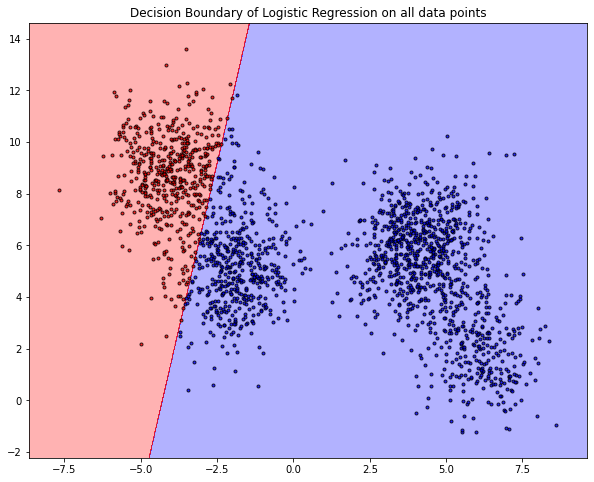

In [26]:
plot_decision_regions(X_training, LR_preds_train, LR_model)
plt.title("Decision Boundary of Logistic Regression on all data points")
plt.show()

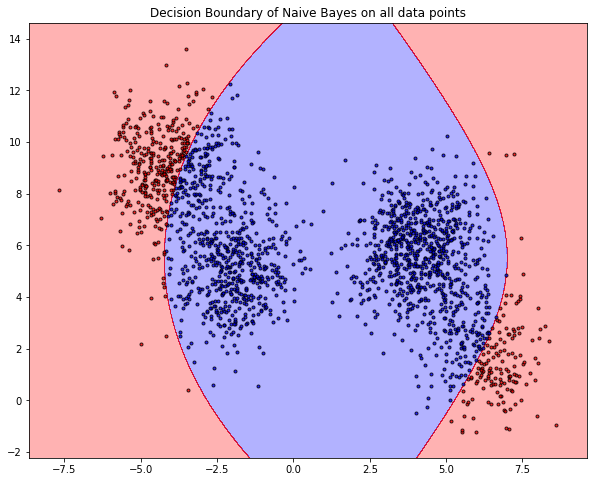

In [27]:
plot_decision_regions(X_training, NB_preds_train, NB_model)
plt.title("Decision Boundary of Naive Bayes on all data points")
plt.show()

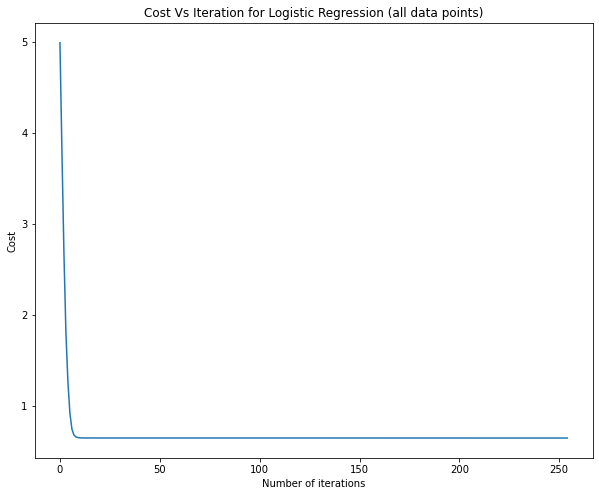

In [28]:
plt.plot(LR_model.cost)
plt.title("Cost Vs Iteration for Logistic Regression (all data points)")
plt.xlabel("Number of iterations")
plt.ylabel("Cost")
plt.show()

## Open question

(7 points) 

Will Full Bayes (Bayes classifier that doesn't use the naive assumption) get better results comparing to Naive Bayes on the following dataset? Explain. 

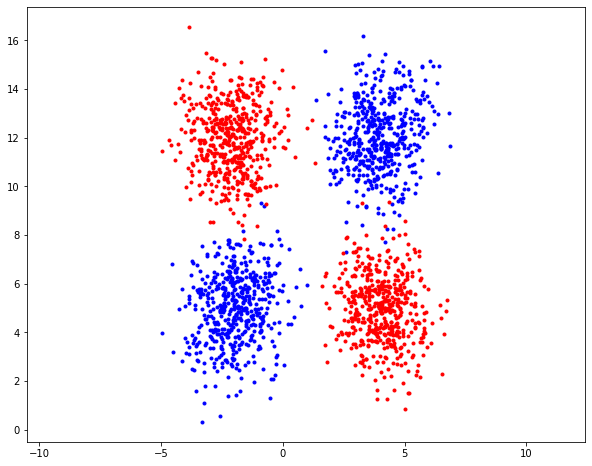

In [29]:
mean = [[-2,5], [-2, 12], [4, 12], [4, 5]]
cov = [[[1,0.2],[0.2,2]], [[1,0],[0,2]], [[1,0.2],[0.2,2]], [[1,-0.2],[-0.2,2]]]
x1 = []
x2 = []
y = []
size = [500, 500, 500, 500]
c = ['b', 'r']
for i in range(4):
    xx1,xx2 = np.random.multivariate_normal(mean[i],cov[i],size[i]).T
    x1.extend(xx1)
    x2.extend(xx2)
    y.extend([i%2] * size[i])
    plt.scatter(xx1,xx2, marker='.', c=c[i%2])
plt.axis('equal')
plt.show()

#### Your answer here ####


Yes, full bayes will get better results compared to innocent bayes.

The naive bayes assume that traits are not interdependent in order to calculate the back probabilities more easily. That is, the value of an attribute in a given class does not depend on the values ​​of other attributes.

It can be seen that according to the numerical calculations the variance is small relative to the variance of each variable. However, this only explains the strong linear dependence between variables and may not reflect a strong nonlinear dependence.

In this example, it can be seen that the variables are very interdependent. Especially considering the class - knowing the class and the value of one attribute, greatly affects the distribution of the second attribute. So the two attributes are coordinated within the two classes hence the assumption that the independent attributes do not hold.

Conclusion: The full bays will get better results in the above data set.